# Using Text Data (Pet Descriptions)
Below, we run a Text Only model as well as a Text model unioned with our numerical model.

In [1]:
# Change this depending on where notebook is running
import os
os.chdir('..')

data_loc = "data/"

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import json
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

import data
from model import *

Using TensorFlow backend.


In [3]:
# Define data locations
train_images = data_loc + "train_images/*"
test_images = data_loc + "test_images/*"

breed_labels_file = data_loc + "breed_labels.csv"
state_labels_file = data_loc + "state_labels.csv"
color_labels_file = data_loc + "color_labels.csv"

train_file = data_loc + "train/train.csv"
test_file = data_loc + "test/test.csv"

train_sentiment_location = data_loc + "train_sentiment"
test_sentiment_location = data_loc + "test_sentiment"

In [4]:
breed_labels = pd.read_csv(breed_labels_file)
state_labels = pd.read_csv(state_labels_file)
color_labels = pd.read_csv(color_labels_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

### Text Parsing

#### Process sentiment metadata
If the data has already been pre-processed, it will be read from disk.

In [5]:
preprocessed_file = "sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(train_df, train_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    train_df = train_df.merge(sentiment, on='PetID')

preprocessed_file = "test_sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(test_df, test_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    test_df = test_df.merge(sentiment, on='PetID')

#### Parse Description

In [6]:
train_sequence, test_sequence, vocab_len = data.parse_description(train_df, test_df)

In [7]:
train_df['Sequence'] = train_sequence
test_df['Sequence'] = test_sequence

In [8]:
display(train_df[['Sequence']][:10])

,Sequence
0,"[10877, 17741, 4659, 24181, 12977, 19131, 5387..."
1,"[14847, 22133, 18264, 13462, 19694, 2128, 4755..."
2,"[3888, 13462, 22781, 14075, 8549, 2235, 19056,..."
3,"[23189, 11893, 21572, 18450, 21112, 13311, 231..."
4,"[23413, 12977, 100, 2238, 21836, 22146, 3926, ..."
5,"[3772, 19520, 7336, 12111, 10617, 14082, 0, 0,..."
6,"[1252, 14162, 14094, 7493, 4278, 16249, 8620, ..."
7,"[2235, 19056, 21836, 14162, 21574, 10435, 6139..."
8,"[24539, 18450, 16147, 19520, 14847, 12597, 353..."
9,"[3766, 1403, 3772, 14847, 10508, 796, 24844, 1..."


### Preprocess Numeric Data - One hot encoding

In [9]:
# One hot encode columns
for col, num_class in data.one_hot_cols.items():
    if col is not 'Breed1' and col is not 'Breed2':
        encode = data.one_hot_encode(train_df, col, num_class, inplace=True)
        encode = data.one_hot_encode(test_df, col, num_class, inplace=True)
        print("One hot encoding {} with {} classes...".format(col, num_class))

One hot encoding Type with 2 classes...
One hot encoding Gender with 3 classes...
One hot encoding Color1 with 7 classes...
One hot encoding Color2 with 7 classes...
One hot encoding Color3 with 7 classes...
One hot encoding MaturitySize with 5 classes...
One hot encoding FurLength with 4 classes...
One hot encoding Vaccinated with 3 classes...
One hot encoding Dewormed with 3 classes...
One hot encoding Sterilized with 3 classes...
One hot encoding Health with 4 classes...
One hot encoding State with 15 classes...


In [10]:
# One hot encode y-output
encode = data.one_hot_encode(train_df, 'AdoptionSpeed', inplace=True)

In [11]:
y_col = ['AdoptionSpeed_0', 'AdoptionSpeed_1', 'AdoptionSpeed_2', 'AdoptionSpeed_3', 'AdoptionSpeed_4']

In [12]:
numeric_cols = list(train_df.columns)
numeric_cols.remove("PetID") # String
numeric_cols.remove("Name") # String
numeric_cols.remove("RescuerID") # String
numeric_cols.remove("Description") # String, processed seperately
numeric_cols.remove("Sequence") # processed seperately

for col in y_col:
    numeric_cols.remove(col)

In [13]:
# Testing columns to remove
numeric_cols.remove('Breed1')
numeric_cols.remove('Breed2')

In [14]:
print(numeric_cols)

['Type', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore', 'NumSentences', 'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'Color2_0', 'Color2_2', 'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0', 'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'FurLength_1', 'FurLength_2', 'FurLength_3', 'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health_1', 'Health_2', 'Health_3', 'State_41324', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415']


In [15]:
# Drop any nans
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
# normalize numeric columns
df = train_df[numeric_cols]
train_df[numeric_cols] = (df - df.min()) / (df.max() - df.min())

#### Handle Breeds

In [17]:
type1_breeds_pca, type2_breeds_pca, type1_breeds_test_pca, type2_breeds_test_pca = data.parse_breeds(train_df, test_df, breed_labels, [0,0.5])

### Split into train and validation sets

In [18]:
text_cols = 'Sequence'

In [19]:
# Create a mask for training and validation data
msk1 = np.random.rand(len(train_df[train_df["Type"]==0])) < 0.8
msk2 = np.random.rand(len(train_df[train_df["Type"]==1])) < 0.8

In [20]:
print(len(msk1), len(msk2))

7439 5776


In [21]:
print("Len total:", len(train_df))
print("Len train:" , len(train_df[train_df["Type"]==0][msk1]))
print("Len valid:", len(train_df[train_df["Type"]==0][~msk1]))

Len total: 13215
Len train: 5980
Len valid: 1459


Split into training and validation data


In [22]:
# Text Data
type1_train_x_text = train_df[train_df["Type"]==0][text_cols][msk1]
type1_train_x_text = pd.DataFrame([row for row in type1_train_x_text]) # To make this correct shape

type1_valid_x_text = train_df[train_df["Type"]==0][text_cols][~msk1]
type1_valid_x_text = pd.DataFrame([row for row in type1_valid_x_text])

print("Train x shape {}".format(type1_train_x_text.shape))
print("Valid x shape {}".format(type1_valid_x_text.shape))


# Text Data
type2_train_x_text = train_df[train_df["Type"]==1][text_cols][msk2]
type2_train_x_text = pd.DataFrame([row for row in type2_train_x_text]) # To make this correct shape

type2_valid_x_text = train_df[train_df["Type"]==1][text_cols][~msk2]
type2_valid_x_text = pd.DataFrame([row for row in type2_valid_x_text])

print("Train x shape {}".format(type2_train_x_text.shape))
print("Valid x shape {}".format(type2_valid_x_text.shape))

Train x shape (5980, 30)
Valid x shape (1459, 30)
Train x shape (4689, 30)
Valid x shape (1087, 30)


In [23]:
# Numeric
type1_train_x_num = train_df[train_df["Type"]==0][numeric_cols][msk1]
type1_valid_x_num = train_df[train_df["Type"]==0][numeric_cols][~msk1]

print("Train x shape {}".format(type1_train_x_num.shape))
print("Valid x shape {}".format(type1_valid_x_num.shape))


# Numeric
type2_train_x_num = train_df[train_df["Type"]==1][numeric_cols][msk2]
type2_valid_x_num = train_df[train_df["Type"]==1][numeric_cols][~msk2]

print("Train x shape {}".format(type2_train_x_num.shape))
print("Valid x shape {}".format(type2_valid_x_num.shape))

Train x shape (5980, 65)
Valid x shape (1459, 65)
Train x shape (4689, 65)
Valid x shape (1087, 65)


In [24]:
# Breeds
type1_train_x_breed = type1_breeds_pca[msk1]
type1_valid_x_breed = type1_breeds_pca[~msk1]

print("Train x shape {}".format(type1_train_x_breed.shape))
print("Valid x shape {}".format(type1_valid_x_breed.shape))

type2_train_x_breed = type2_breeds_pca[msk2]
type2_valid_x_breed = type2_breeds_pca[~msk2]

print("Train x shape {}".format(type2_train_x_breed.shape))
print("Valid x shape {}".format(type2_valid_x_breed.shape))

Train x shape (5980, 64)
Valid x shape (1459, 64)
Train x shape (4689, 64)
Valid x shape (1087, 64)


In [25]:
# The y's are the same for both text and numerical models
type1_train_y = train_df[train_df["Type"]==0][y_col][msk1]
type1_valid_y = train_df[train_df["Type"]==0][y_col][~msk1]


# The y's are the same for both text and numerical models
type2_train_y = train_df[train_df["Type"]==1][y_col][msk2]
type2_valid_y = train_df[train_df["Type"]==1][y_col][~msk2]

## Text Only Model
Defined in model.py as TextOnlyModel

#### Type 1

In [26]:
type1_text_model = TextOnlyModel((type1_train_x_text, type1_train_y),
                           (type1_valid_x_text, type1_valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [27]:
type1_text_model.compile()
type1_text_model.train(epochs=10)

Train on 5980 samples, validate on 1459 samples
Epoch 1/10
5980/5980 [==============================] - 31s 5ms/step - loss: 1.4677 - acc: 0.2721 - val_loss: 1.4430 - val_acc: 0.2461
Epoch 2/10
5980/5980 [==============================] - 22s 4ms/step - loss: 1.4399 - acc: 0.3013 - val_loss: 1.4332 - val_acc: 0.2858
Epoch 3/10
5980/5980 [==============================] - 22s 4ms/step - loss: 1.3438 - acc: 0.3796 - val_loss: 1.4196 - val_acc: 0.3276
Epoch 4/10
5980/5980 [==============================] - 23s 4ms/step - loss: 1.2018 - acc: 0.4711 - val_loss: 1.4554 - val_acc: 0.3461
Epoch 5/10
5980/5980 [==============================] - 23s 4ms/step - loss: 1.0592 - acc: 0.5450 - val_loss: 1.5482 - val_acc: 0.3427
Epoch 6/10
5980/5980 [==============================] - 23s 4ms/step - loss: 0.9528 - acc: 0.6032 - val_loss: 1.6883 - val_acc: 0.3509
Epoch 7/10
5980/5980 [==============================] - 22s 4ms/step - loss: 0.8673 - acc: 0.6574 - val_loss: 1.7063 - val_acc: 0.3482
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


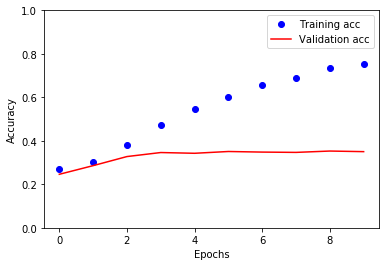

In [28]:
history = type1_text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [29]:
valid_pred = type1_text_model.predict(type1_valid_x_text)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type1_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.16306203762384774


#### Type 2

In [30]:
type2_train_x_text

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,10877.0,17741.0,4659.0,24181.0,12977.0,19131.0,5387.0,3722.0,10877.0,22704.0,...,16470.0,19109.0,3722.0,5882.0,9256.0,19312.0,15051.0,7.0,3926.0,19109.0
1,14847.0,22133.0,18264.0,13462.0,19694.0,2128.0,4755.0,17091.0,5993.0,11890.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3766.0,1403.0,3772.0,14847.0,10508.0,796.0,24844.0,14847.0,17091.0,14082.0,...,14094.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19073.0,16964.0,23928.0,5639.0,6291.0,10508.0,5461.0,12111.0,22133.0,22861.0,...,3362.0,14059.0,9256.0,23189.0,22364.0,17091.0,21946.0,21237.0,14059.0,628.0
4,19976.0,2235.0,19056.0,9428.0,11836.0,19520.0,7.0,19109.0,19976.0,19520.0,...,10886.0,23968.0,5525.0,3772.0,16597.0,14094.0,9256.0,23189.0,16174.0,17091.0
5,23402.0,5477.0,15601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3722.0,5664.0,14086.0,12093.0,22725.0,3766.0,11350.0,19520.0,19126.0,6489.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,21032.0,3612.0,24189.0,6271.0,9093.0,15602.0,2303.0,20518.0,3285.0,14094.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5475.0,19253.0,2592.0,9601.0,17884.0,23716.0,22733.0,23189.0,3722.0,23552.0,...,5789.0,14162.0,14094.0,9773.0,14059.0,2235.0,21574.0,24743.0,24595.0,5986.0
9,24539.0,19142.0,16341.0,11836.0,5185.0,9256.0,12977.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
type2_text_model = TextOnlyModel((type2_train_x_text, type2_train_y),
                           (type2_valid_x_text, type2_valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [32]:
type2_text_model.compile()
type2_text_model.train(epochs=10)

Train on 4689 samples, validate on 1087 samples
Epoch 1/10
4689/4689 [==============================] - 27s 6ms/step - loss: 1.5030 - acc: 0.2606 - val_loss: 1.4824 - val_acc: 0.2797
Epoch 2/10
4689/4689 [==============================] - 17s 4ms/step - loss: 1.4731 - acc: 0.2871 - val_loss: 1.4699 - val_acc: 0.2741
Epoch 3/10
4689/4689 [==============================] - 17s 4ms/step - loss: 1.4159 - acc: 0.3374 - val_loss: 1.4858 - val_acc: 0.3100
Epoch 4/10
4689/4689 [==============================] - 17s 4ms/step - loss: 1.3203 - acc: 0.4127 - val_loss: 1.4774 - val_acc: 0.3174
Epoch 5/10
4689/4689 [==============================] - 18s 4ms/step - loss: 1.2137 - acc: 0.4756 - val_loss: 1.6033 - val_acc: 0.3119
Epoch 6/10
4689/4689 [==============================] - 17s 4ms/step - loss: 1.1017 - acc: 0.5451 - val_loss: 1.6511 - val_acc: 0.3293
Epoch 7/10
4689/4689 [==============================] - 17s 4ms/step - loss: 0.9990 - acc: 0.6023 - val_loss: 1.8628 - val_acc: 0.3201
Epoch 8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


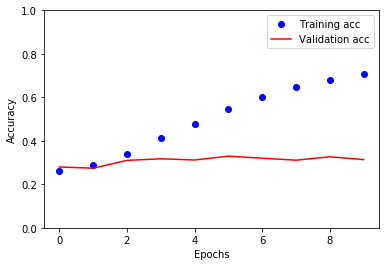

In [33]:
history = type2_text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [34]:
valid_pred = type2_text_model.predict(type2_valid_x_text)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type2_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.0782456678858664


In [35]:
# Testing how one model performs on the other's data
# Irrelevant.
from sklearn.metrics import accuracy_score
type1_pred_on_type2_model = type2_text_model.predict(type1_valid_x_text)
type1_pred_on_type2_model = np.argmax(type1_pred_on_type2_model, -1)

y_true_test = np.argmax(np.array(type1_valid_y), -1)
accuracy_score(y_true_test, type1_pred_on_type2_model)

0.25496915695681976

## Numerical Model

In [36]:
class ImageFreeModel(KaggleModel):
    def __init__(self, train, test, shape):
        kernel = Sequential(name='image_free_encoder')
        
        kernel.add(BatchNormalization(input_shape=(shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Activation('relu'))
        
        kernel.add(Dense(64, activation='relu'))
        
        kernel.add(Dense(32, activation='relu'))

        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='image_free')
        model.add(kernel)
        
        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
type1_numerical_model = ImageFreeModel((type1_train_x_num, type1_train_y),
                                 (type1_valid_x_num, type1_valid_y),
                                 type1_train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [38]:
type1_numerical_model.compile()
type1_numerical_model.train(epochs=10)

Train on 5980 samples, validate on 1459 samples
Epoch 1/10
5980/5980 [==============================] - 4s 636us/step - loss: 1.4187 - acc: 0.3477 - val_loss: 1.3807 - val_acc: 0.3715
Epoch 2/10
5980/5980 [==============================] - 1s 173us/step - loss: 1.3569 - acc: 0.3943 - val_loss: 1.3750 - val_acc: 0.3674
Epoch 3/10
5980/5980 [==============================] - 1s 172us/step - loss: 1.3279 - acc: 0.4057 - val_loss: 1.3767 - val_acc: 0.3845
Epoch 4/10
5980/5980 [==============================] - 1s 166us/step - loss: 1.2996 - acc: 0.4324 - val_loss: 1.3812 - val_acc: 0.3783
Epoch 5/10
5980/5980 [==============================] - 1s 170us/step - loss: 1.2852 - acc: 0.4343 - val_loss: 1.3894 - val_acc: 0.3763
Epoch 6/10
5980/5980 [==============================] - 1s 171us/step - loss: 1.2584 - acc: 0.4495 - val_loss: 1.4120 - val_acc: 0.3722
Epoch 7/10
5980/5980 [==============================] - 1s 170us/step - loss: 1.2389 - acc: 0.4672 - val_loss: 1.4236 - val_acc: 0.3722


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


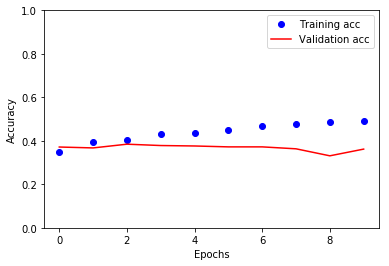

In [39]:
history = type1_numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [40]:
valid_pred = type1_numerical_model.predict(type1_valid_x_num)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type1_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.2343254830482201


In [41]:
type2_numerical_model = ImageFreeModel((type2_train_x_num, type2_train_y),
                                 (type2_valid_x_num, type2_valid_y),
                                 type2_train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [42]:
type2_numerical_model.compile()
type2_numerical_model.train(epochs=10)

Train on 4689 samples, validate on 1087 samples
Epoch 1/10
4689/4689 [==============================] - 4s 793us/step - loss: 1.4709 - acc: 0.3101 - val_loss: 1.4351 - val_acc: 0.3468
Epoch 2/10
4689/4689 [==============================] - 1s 171us/step - loss: 1.4016 - acc: 0.3732 - val_loss: 1.4452 - val_acc: 0.3560
Epoch 3/10
4689/4689 [==============================] - 1s 173us/step - loss: 1.3689 - acc: 0.3994 - val_loss: 1.4359 - val_acc: 0.3487
Epoch 4/10
4689/4689 [==============================] - 1s 171us/step - loss: 1.3396 - acc: 0.4167 - val_loss: 1.4380 - val_acc: 0.3459
Epoch 5/10
4689/4689 [==============================] - 1s 173us/step - loss: 1.3255 - acc: 0.4240 - val_loss: 1.4504 - val_acc: 0.3404
Epoch 6/10
4689/4689 [==============================] - 1s 170us/step - loss: 1.2890 - acc: 0.4440 - val_loss: 1.4598 - val_acc: 0.3459
Epoch 7/10
4689/4689 [==============================] - 1s 168us/step - loss: 1.2635 - acc: 0.4662 - val_loss: 1.4900 - val_acc: 0.3413


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


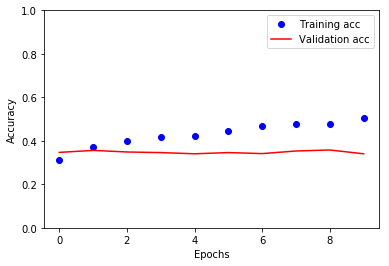

In [43]:
history = type2_numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [44]:
valid_pred = type2_numerical_model.predict(type2_valid_x_num)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type2_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.220691677220469


## Union Model - Text + Num
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [45]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [46]:
type1_union_model = UnionModel2([type1_text_model, type1_numerical_model],
                         ([type1_train_x_text, type1_train_x_num], type1_train_y),
                         ([type1_valid_x_text, type1_valid_x_num], type1_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [47]:
type1_union_model.compile()
type1_union_model.train(epochs=10)

Train on 5980 samples, validate on 1459 samples
Epoch 1/10
5980/5980 [==============================] - 11s 2ms/step - loss: 0.5893 - acc: 0.8018 - val_loss: 2.7820 - val_acc: 0.3804
Epoch 2/10
5980/5980 [==============================] - 4s 679us/step - loss: 0.5409 - acc: 0.8132 - val_loss: 2.2537 - val_acc: 0.3633
Epoch 3/10
5980/5980 [==============================] - 4s 752us/step - loss: 0.5237 - acc: 0.8162 - val_loss: 2.3446 - val_acc: 0.3797
Epoch 4/10
5980/5980 [==============================] - 4s 722us/step - loss: 0.5109 - acc: 0.8211 - val_loss: 2.3429 - val_acc: 0.3681
Epoch 5/10
5980/5980 [==============================] - 5s 776us/step - loss: 0.5215 - acc: 0.8132 - val_loss: 2.3665 - val_acc: 0.3674
Epoch 6/10
5980/5980 [==============================] - 4s 700us/step - loss: 0.5012 - acc: 0.8224 - val_loss: 2.1053 - val_acc: 0.3578
Epoch 7/10
5980/5980 [==============================] - 4s 733us/step - loss: 0.5059 - acc: 0.8231 - val_loss: 2.0352 - val_acc: 0.3537
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


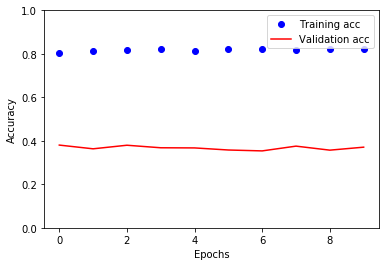

In [48]:
history = type1_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [49]:
valid_pred = type1_union_model.predict([type1_valid_x_text, type1_valid_x_num])
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type1_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.22092993483270418


In [50]:
type2_union_model = UnionModel2([type2_text_model, type2_numerical_model],
                         ([type2_train_x_text, type2_train_x_num], type2_train_y),
                         ([type2_valid_x_text, type2_valid_x_num], type2_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [51]:
type2_union_model.compile()
type2_union_model.train(epochs=10)

Train on 4689 samples, validate on 1087 samples
Epoch 1/10
4689/4689 [==============================] - 10s 2ms/step - loss: 0.6729 - acc: 0.7562 - val_loss: 2.4194 - val_acc: 0.3358
Epoch 2/10
4689/4689 [==============================] - 3s 705us/step - loss: 0.5828 - acc: 0.7927 - val_loss: 2.7216 - val_acc: 0.3238
Epoch 3/10
4689/4689 [==============================] - 3s 696us/step - loss: 0.5726 - acc: 0.7978 - val_loss: 2.4676 - val_acc: 0.3468
Epoch 4/10
4689/4689 [==============================] - 3s 713us/step - loss: 0.5496 - acc: 0.7987 - val_loss: 2.3817 - val_acc: 0.3487
Epoch 5/10
4689/4689 [==============================] - 3s 711us/step - loss: 0.5452 - acc: 0.8061 - val_loss: 2.4850 - val_acc: 0.3477
Epoch 6/10
4689/4689 [==============================] - 3s 694us/step - loss: 0.5561 - acc: 0.7991 - val_loss: 2.4829 - val_acc: 0.3487
Epoch 7/10
4689/4689 [==============================] - 3s 715us/step - loss: 0.5389 - acc: 0.8025 - val_loss: 2.2958 - val_acc: 0.3487
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


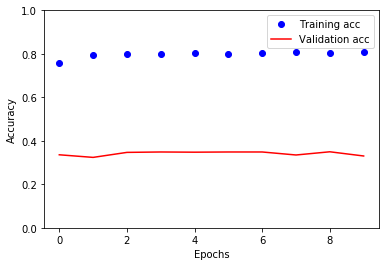

In [52]:
history = type2_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [53]:
valid_pred = type2_union_model.predict([type2_valid_x_text, type2_valid_x_num])
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type2_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.13883726230695326


## Breeds Model

In [54]:
class BreedModel(KaggleModel):
    def __init__(self, train, test, input_shape=64):
        kernel = Sequential(name='breeds_encoder')
        
        kernel.add(BatchNormalization(input_shape=(input_shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Dense(128))
        
        kernel.add(Dense(64))
        kernel.add(Dense(64))

        kernel.add(Dense(32))
        kernel.add(Dense(32))
        
        
        kernel.add(Activation('relu'))
        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='breed')
        model.add(kernel)
        
        model.add(Dense(64, activation='relu'))

        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)
    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
type1_breeds_model = BreedModel((type1_train_x_breed, type1_train_y),
                                 (type1_valid_x_breed, type1_valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                40640     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 325       
Total params: 43,077
Trainable params: 42,949
Non-trainable params: 128
_________________________________________________________________


In [56]:
type1_breeds_model.compile()
type1_breeds_model.train(epochs=10)

Train on 5980 samples, validate on 1459 samples
Epoch 1/10
5980/5980 [==============================] - 5s 789us/step - loss: 1.4764 - acc: 0.2717 - val_loss: 1.4407 - val_acc: 0.2995
Epoch 2/10
5980/5980 [==============================] - 2s 267us/step - loss: 1.4467 - acc: 0.2898 - val_loss: 1.4508 - val_acc: 0.2934
Epoch 3/10
5980/5980 [==============================] - 2s 266us/step - loss: 1.4412 - acc: 0.2970 - val_loss: 1.4503 - val_acc: 0.2742
Epoch 4/10
5980/5980 [==============================] - 1s 236us/step - loss: 1.4372 - acc: 0.2978 - val_loss: 1.4637 - val_acc: 0.2954
Epoch 5/10
5980/5980 [==============================] - 1s 207us/step - loss: 1.4380 - acc: 0.2926 - val_loss: 1.4690 - val_acc: 0.3009
Epoch 6/10
5980/5980 [==============================] - 1s 242us/step - loss: 1.4365 - acc: 0.2990 - val_loss: 1.4602 - val_acc: 0.2954
Epoch 7/10
5980/5980 [==============================] - 1s 196us/step - loss: 1.4333 - acc: 0.2948 - val_loss: 1.4741 - val_acc: 0.2906


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


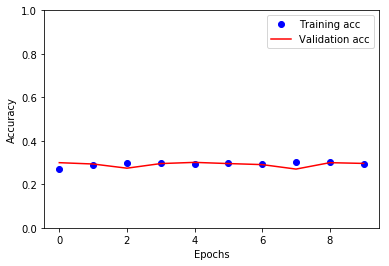

In [57]:
history = type1_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [58]:
valid_pred = type1_breeds_model.predict(type1_valid_x_breed)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type1_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.0552343475146716


In [59]:
type2_breeds_model = BreedModel((type2_train_x_breed, type2_train_y),
                                 (type2_valid_x_breed, type2_valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                40640     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 325       
Total params: 43,077
Trainable params: 42,949
Non-trainable params: 128
_________________________________________________________________


In [60]:
type2_breeds_model.compile()
type2_breeds_model.train(epochs=10)

Train on 4689 samples, validate on 1087 samples
Epoch 1/10
4689/4689 [==============================] - 5s 1ms/step - loss: 1.5184 - acc: 0.2576 - val_loss: 1.4819 - val_acc: 0.2824
Epoch 2/10
4689/4689 [==============================] - 1s 221us/step - loss: 1.4864 - acc: 0.2681 - val_loss: 1.5050 - val_acc: 0.2576
Epoch 3/10
4689/4689 [==============================] - 1s 264us/step - loss: 1.4854 - acc: 0.2702 - val_loss: 1.4869 - val_acc: 0.2861
Epoch 4/10
4689/4689 [==============================] - 1s 217us/step - loss: 1.4792 - acc: 0.2768 - val_loss: 1.4990 - val_acc: 0.2852
Epoch 5/10
4689/4689 [==============================] - 1s 193us/step - loss: 1.4805 - acc: 0.2651 - val_loss: 1.4981 - val_acc: 0.2861
Epoch 6/10
4689/4689 [==============================] - 1s 251us/step - loss: 1.4757 - acc: 0.2790 - val_loss: 1.5034 - val_acc: 0.2824
Epoch 7/10
4689/4689 [==============================] - 1s 190us/step - loss: 1.4781 - acc: 0.2764 - val_loss: 1.5041 - val_acc: 0.2769
Ep

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


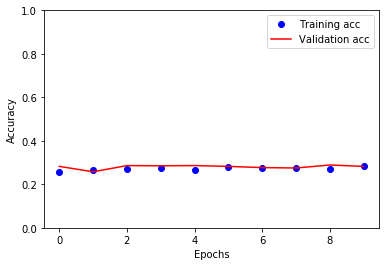

In [61]:
history = type2_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [62]:
valid_pred = type2_breeds_model.predict(type2_valid_x_breed)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type2_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.01397336914401115


## Union Model - Text + Num + Breeds
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [63]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dropout(0.5)(y)
        y = Dense(128)(y)
#         y = Dropout(0.5)(y)
        y = Dense(64)(y)
#         y = Dropout(0.5)(y)
        y = Dense(64)(y)
#         y = Dropout(0.5)(y)
        y = Dense(32)(y)
        y = Dense(32)(y)
        
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [64]:
type1_union_model = UnionModel2([type1_text_model, type1_numerical_model, type1_breeds_model],
                         ([type1_train_x_text, type1_train_x_num, type1_train_x_breed], type1_train_y),
                         ([type1_valid_x_text, type1_valid_x_num, type1_valid_x_breed], type1_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
breed_in (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free

In [65]:
type1_union_model.compile()
type1_union_model.train(epochs=50)

Train on 5980 samples, validate on 1459 samples
Epoch 1/50
5980/5980 [==============================] - 12s 2ms/step - loss: 0.6851 - acc: 0.7671 - val_loss: 2.3724 - val_acc: 0.3735
Epoch 2/50
5980/5980 [==============================] - 5s 768us/step - loss: 0.5869 - acc: 0.8007 - val_loss: 2.2552 - val_acc: 0.3749
Epoch 3/50
5980/5980 [==============================] - 4s 741us/step - loss: 0.5612 - acc: 0.8094 - val_loss: 2.3634 - val_acc: 0.3742
Epoch 4/50
5980/5980 [==============================] - 4s 714us/step - loss: 0.5489 - acc: 0.8120 - val_loss: 2.2802 - val_acc: 0.3667
Epoch 5/50
5980/5980 [==============================] - 5s 760us/step - loss: 0.5364 - acc: 0.8115 - val_loss: 2.2958 - val_acc: 0.3646
Epoch 6/50
5980/5980 [==============================] - 5s 772us/step - loss: 0.5254 - acc: 0.8142 - val_loss: 2.3177 - val_acc: 0.3674
Epoch 7/50
5980/5980 [==============================] - 5s 767us/step - loss: 0.5262 - acc: 0.8187 - val_loss: 2.2665 - val_acc: 0.3729
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


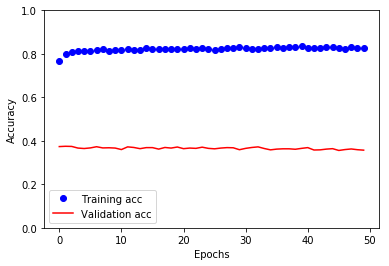

In [66]:
history = type1_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [67]:
valid_pred = type1_union_model.predict([type1_valid_x_text, type1_valid_x_num, type1_valid_x_breed])
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type1_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.20272458591958586


In [68]:
type2_union_model = UnionModel2([type2_text_model, type2_numerical_model, type2_breeds_model],
                         ([type2_train_x_text, type2_train_x_num, type2_train_x_breed], type2_train_y),
                         ([type2_valid_x_text, type2_valid_x_num, type2_valid_x_breed], type2_valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
breed_in (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free

In [69]:
type2_union_model.compile()
type2_union_model.train(epochs=10)

Train on 4689 samples, validate on 1087 samples
Epoch 1/10
4689/4689 [==============================] - 13s 3ms/step - loss: 0.7710 - acc: 0.7270 - val_loss: 2.2005 - val_acc: 0.3477
Epoch 2/10
4689/4689 [==============================] - 4s 762us/step - loss: 0.6436 - acc: 0.7686 - val_loss: 2.3262 - val_acc: 0.3588
Epoch 3/10
4689/4689 [==============================] - 3s 736us/step - loss: 0.6166 - acc: 0.7814 - val_loss: 2.3510 - val_acc: 0.3523
Epoch 4/10
4689/4689 [==============================] - 4s 773us/step - loss: 0.5947 - acc: 0.7848 - val_loss: 2.2865 - val_acc: 0.3551
Epoch 5/10
4689/4689 [==============================] - 4s 760us/step - loss: 0.5739 - acc: 0.7912 - val_loss: 2.2400 - val_acc: 0.3551
Epoch 6/10
4689/4689 [==============================] - 4s 820us/step - loss: 0.5590 - acc: 0.7933 - val_loss: 2.3732 - val_acc: 0.3579
Epoch 7/10
4689/4689 [==============================] - 4s 747us/step - loss: 0.5624 - acc: 0.7914 - val_loss: 2.3380 - val_acc: 0.3523
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


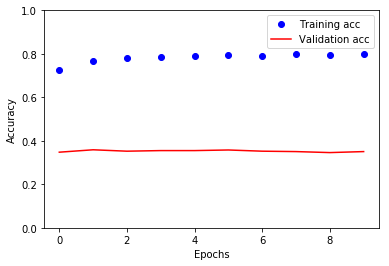

In [70]:
history = type2_union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [71]:
valid_pred = type2_union_model.predict([type2_valid_x_text, type2_valid_x_num, type2_valid_x_breed])
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(type2_valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.14656952878975038
